In [1]:
%pylab inline
from __future__ import division
from matplotlib import pyplot as plt
import tensorflow as tf
import pprint
import random
import numpy as np
import PIL.Image as pil
from PIL import Image
from glob import glob
import cv2


import tensorflow.contrib.slim.nets

from imageselect_Dataloader_optflow import DataLoader
import os

from nets_optflow_depth import *
import util

Populating the interactive namespace from numpy and matplotlib


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS
FLAGS.dataset_dir = "./data"
FLAGS.output_dir = "./output/"
FLAGS.image_height = 192
FLAGS.image_width = 256
FLAGS = flags.FLAGS
FLAGS.resizedheight = 192
FLAGS.resizedwidth = 256
FLAGS.checkpoint_dir="./checkpoints"
FLAGS.checkpoint_dir_single="./checkpoints_single"
#FLAGS.init_checkpoint_file = "./checkpoints/model-70000"

In [3]:
with tf.Graph().as_default():
    #Load image and label
    imgleft = tf.placeholder(shape=[1, FLAGS.resizedheight, FLAGS.resizedwidth, 3], dtype=tf.float32)
    imgright = tf.placeholder(shape=[1, FLAGS.resizedheight, FLAGS.resizedwidth, 3], dtype=tf.float32)
    
        # # Define the model:
#     with tf.variable_scope("model_pairdepth") as scope:

#         inputdata = tf.concat([imgleft, imgright], axis=3)

#         pred_depth_left, pred_poses_right, pred_exp_logits_left, depth_net_endpoints_left = depth_net(inputdata,                                                    
#                                                                                             is_training=False)
#         saver_pair = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'model_pairdepth'))
#         #saver_pair = tf.train.Saver([var for var in tf.model_variables()])
#         checkpoint_pair = tf.train.latest_checkpoint(FLAGS.checkpoint_dir)


    with tf.variable_scope("model_singledepth") as scope:


        #estimate depth and optical flow from both left and right image
#         _, height, width, _ = imgleft.get_shape().as_list()

#         pred_depth_left_up = tf.image.resize_nearest_neighbor(pred_depth_left[0], [height, width])

#         inputdata_single = tf.concat([pred_depth_left_up,imgleft], axis=3)
        pred_depth_single_left,depth_endpoints = disp_net(imgleft,                                                 
                                              is_training=False)

        saver_single = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'model_singledepth'))

        checkpoint_single = tf.train.latest_checkpoint(FLAGS.checkpoint_dir_single)                


    with tf.Session() as sess:
        tf.initialize_all_variables().run()
        tf.initialize_local_variables().run()

        #saver_pair.restore(sess, checkpoint_pair)
        saver_single.restore(sess,checkpoint_single)

        img_list = sorted(glob(FLAGS.dataset_dir + '/*.png'))


        #import pdb;pdb.set_trace()
        for i in range(len(img_list)-1):

            I = Image.open(img_list[i])
            I1 = Image.open(img_list[i+1])
            I = I.resize((FLAGS.resizedwidth, FLAGS.resizedheight),pil.ANTIALIAS)
            I1 = I1.resize((FLAGS.resizedwidth, FLAGS.resizedheight),pil.ANTIALIAS)
            # I = np.array(I)
            # I1 = np.array(I1)

            # I = I.astype(np.float32)
            # I1 = I1.astype(np.float32)

            I = np.array(I).astype(np.float32)/255.0 -0.5
            I1 = np.array(I1).astype(np.float32)/255.0 -0.5
            #import pdb;pdb.set_trace()

            #inputdata = np.concatenate([I[np.newaxis,:],I1[np.newaxis,:]],axis=3)

            pred_single = sess.run(pred_depth_single_left,feed_dict={imgleft: I[np.newaxis,:],
                                                                     imgright: I1[np.newaxis,:],
                                                                     })

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.local_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from ./checkpoints_single/model-400000


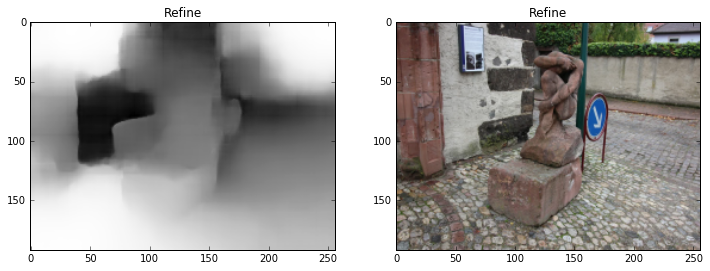

In [5]:
# z_coarse = pred[0][0,:,:,0]
z = 1./pred_single[0][0,:,:,0]



fig = plt.figure(figsize=(12, 12))

# m_plot = fig.add_subplot(1, 3, 1)
# imgplot = plt.imshow(z_coarse, cmap='Greys')
# m_plot.set_title('Coarse')

m_plot = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(z, cmap='Greys')
m_plot.set_title('Refine')

m_plot = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(((I+0.5)*255).astype(np.uint8))
m_plot.set_title('Refine')

#print(pose)

In [6]:
z=cv2.resize(pred_single[0][0,:,:,:],(FLAGS.image_width,FLAGS.image_height),interpolation = cv2.INTER_CUBIC)
z = cv2.bilateralFilter(z,9,75,75)
#z=1.0/z#[0][0,:,:,0]
z.astype(np.float32).tofile(FLAGS.output_dir+img_list[i].split('/')[-1]+'_z.bin')

print("The %dth frame is processed"%(i))

The 0th frame is processed
